# Car Price Project - Modeling

## Import Python Libraries and Data

In [4]:
#Data wrangling
import numpy as np 
import pandas as pd
import os

#Data Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

#Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

#Model Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#Model evaluation
from sklearn import metrics

# Save model
import pickle

# Set output as pandas
from sklearn import set_config
set_config(transform_output="pandas")

In [5]:
## -- Functions - ##
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'Mean Absolute Error':float(metrics.mean_absolute_error(y_true, y_pred)),
        'Mean Squared Error':float(metrics.mean_squared_error(y_true, y_pred)),
        'Root Mean Squared Error':float(metrics.mean_absolute_error(y_true, y_pred)**0.5),
        'R-Squared':float(metrics.r2_score(y_true, y_pred)),
    }
    return dict_metrics

In [6]:
pd.set_option('display.max_rows', None)  # Mostrar todas as linhas
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas

In [7]:
df = pd.read_csv("../data/data.csv")

In [8]:
df.head()

,price,year,condition,cylinders,fuel,odometer,transmission,drive,manufacturer_grouped,type_grouped,color_grouped
0,15000,2013,excellent,6 cylinders,gas,128000.0,automatic,rwd,ford,truck/pickup,black
1,27990,2012,good,8 cylinders,gas,68696.0,other,4wd,gmc,truck/pickup,black
2,34590,2016,good,6 cylinders,gas,29499.0,other,4wd,chevrolet,truck/pickup,silver
3,35000,2019,excellent,6 cylinders,gas,43000.0,automatic,4wd,toyota,truck/pickup,grey
4,29990,2016,good,6 cylinders,gas,17302.0,other,4wd,chevrolet,truck/pickup,red


# Modeling and Evaluation

In [9]:
#Separating Features (x) from Target (y)
X = df.drop(columns='price')
y = df['price']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Pipeline

In [11]:
categorical_features = X.select_dtypes(include=object).columns
numerical_features = X.select_dtypes(exclude=object).columns

In [12]:
preprocessing = ColumnTransformer([
    ('Numerical Columns',SimpleImputer(strategy='mean'),numerical_features),
    ('Categorical Columns', OneHotEncoder(sparse_output=False), categorical_features)]
    )
preprocessing

ColumnTransformer(transformers=[('Numerical Columns', SimpleImputer(),
                                 Index(['year', 'odometer'], dtype='object')),
                                ('Categorical Columns',
                                 OneHotEncoder(sparse_output=False),
                                 Index(['condition', 'cylinders', 'fuel', 'transmission', 'drive',
       'manufacturer_grouped', 'type_grouped', 'color_grouped'],
      dtype='object'))])

In [13]:
model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', DummyRegressor())
])

model_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Numerical Columns',
                                                  SimpleImputer(),
                                                  Index(['year', 'odometer'], dtype='object')),
                                                 ('Categorical Columns',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['condition', 'cylinders', 'fuel', 'transmission', 'drive',
       'manufacturer_grouped', 'type_grouped', 'color_grouped'],
      dtype='object'))])),
                ('model', DummyRegressor())])

In [11]:

params = {
    'model': [
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor(random_state=42),
        DummyRegressor()
    ] 
}

grid = GridSearchCV(model_pipeline,params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

df_grid_results = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')]

Fitting 3 folds for each of 3 candidates, totalling 9 fits


,mean_score_time,std_score_time,param_model,params,mean_test_score,std_test_score
rank_test_score,,,,,,
1,0.894646,0.006311,RandomForestRegressor(random_state=42),{'model': RandomForestRegressor(random_state=42)},-1.478875e+07,274620.805887
2,0.155334,0.023425,GradientBoostingRegressor(random_state=42),{'model': GradientBoostingRegressor(random_sta...,-2.811616e+07,443776.030183
3,0.091937,0.005764,DummyRegressor(),{'model': DummyRegressor()},-1.318724e+08,971125.528086


In [24]:
model = grid.best_estimator_
best_model = model.named_steps['model']
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)

{'Mean Absolute Error': 2409.1750590529036,
 'Mean Squared Error': 19161248.47660635,
 'Root Mean Squared Error': 49.08334808316262,
 'R-Squared': 0.8508940487675952}

Feature Importances

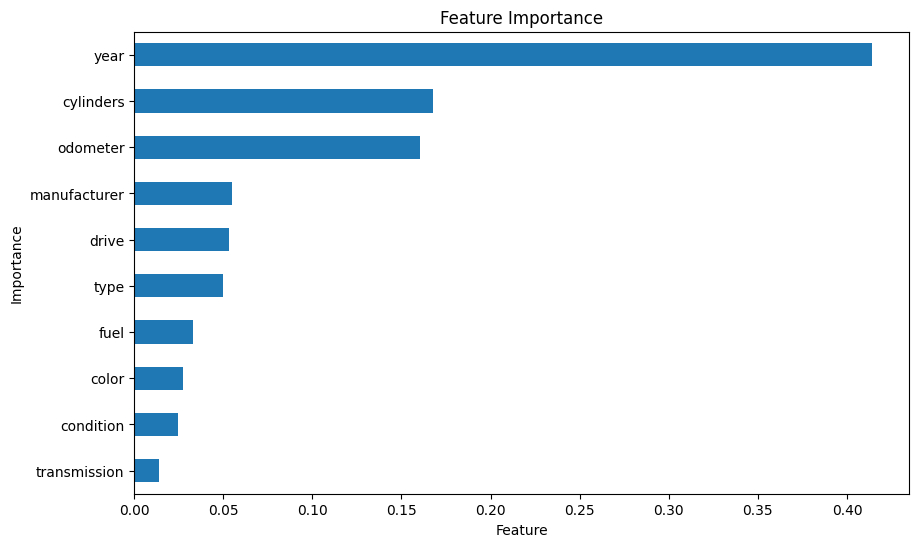

In [13]:
feature_importances = best_model.feature_importances_
feature_names = numerical_features.tolist() + list(grid.best_estimator_['preprocessing'].transformers_[1][1].get_feature_names_out(categorical_features))

importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

importances_df['original_feature'] = importances_df['feature'].str.split('_').str[0]
grouped_importances = importances_df.groupby('original_feature')['importance'].sum().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
grouped_importances.plot(kind='barh')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()


## Simplifying and tunning the model

To make the model lighter and with better processing performance, we will use only a sample of 30% of the original DF.

In [46]:
sample_df = df.sample(frac=0.30, random_state=42)

In [47]:
X = sample_df.drop(columns='price')
y = sample_df['price']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
preprocessing = ColumnTransformer([
    ('Numerical Columns',SimpleImputer(strategy='mean'),numerical_features),
    ('Categorical Columns', OneHotEncoder(sparse_output=False), categorical_features)]
    )

model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', RandomForestRegressor(random_state=42))
])

params = {
    'model__n_estimators':[100,200,300],
    'model__max_depth': [10,30,None]
}

grid = GridSearchCV(model_pipeline,params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

df_grid_results = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
df_grid_results.iloc[:,~df_grid_results.columns.str.contains('split|fit')]


Fitting 3 folds for each of 9 candidates, totalling 27 fits


,mean_score_time,std_score_time,param_model__max_depth,param_model__n_estimators,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.682208,0.095034,None,300,"{'model__max_depth': None, 'model__n_estimator...",-2.704961e+07,840554.168073
2,1.744359,0.319257,30,300,"{'model__max_depth': 30, 'model__n_estimators'...",-2.707630e+07,847564.229877
3,0.889912,0.019532,None,200,"{'model__max_depth': None, 'model__n_estimator...",-2.708164e+07,799284.256080
4,1.257894,0.036028,30,200,"{'model__max_depth': 30, 'model__n_estimators'...",-2.710650e+07,814614.849566
5,0.810908,0.232200,None,100,"{'model__max_depth': None, 'model__n_estimator...",-2.723342e+07,848419.962747
6,1.025004,0.092680,30,100,"{'model__max_depth': 30, 'model__n_estimators'...",-2.723424e+07,862398.767560
7,1.161002,0.216353,10,300,"{'model__max_depth': 10, 'model__n_estimators'...",-3.030516e+07,562295.514080
8,0.743503,0.063475,10,200,"{'model__max_depth': 10, 'model__n_estimators'...",-3.031571e+07,569412.375337
9,0.346967,0.013630,10,100,"{'model__max_depth': 10, 'model__n_estimators'...",-3.035186e+07,563572.520152


In [50]:
tuned_model = grid.best_estimator_
y_pred = tuned_model.predict(X_test)
get_metrics(y_test, y_pred)

{'Mean Absolute Error': 2954.391277861623,
 'Mean Squared Error': 24568211.266996108,
 'Root Mean Squared Error': 54.35431241273891,
 'R-Squared': 0.8043986134536436}

# Deployment

In [51]:
with open('../models/model.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)